In [1]:
genome = "1196095.186"
if False:
    from subprocess import run
    for genome in genomes:
        run(('scp "alive.bio.uu.nl:/hosts/linuxhome/mgx/DB/PATRIC/patricdb-201*/%s.fna" /home/hielke/bep/genomes' 
             % genome).split())

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

In [5]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [6]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [7]:
df_contigs_size = pd.read_csv(data_folder + 'contig_metadata_patric_genomes', sep='\t', 
                        names=['genome_id', 'contig', 'size'], 
                         dtype={'genome_id': str, 'size': int}).set_index('genome_id')
df_contigs_size.head()

,contig,size
genome_id,,
100053.4,JQGS01000001,2023
100053.4,JQGS01000002,25623
100053.4,JQGS01000003,11202
100053.4,JQGS01000004,109309
100053.4,JQGS01000005,13452


In [8]:
df_genome_info = pd.read_csv(data_folder + 'genome_info', sep='\t',
                            names=['genome_id', 'name'],
                            dtype={'genome_id': str}).set_index('genome_id')
df_genome_info.head()

,name
genome_id,
100053.4,Leptospira alexanderi strain 56650
100053.5,Leptospira alexanderi strain 56643
100053.6,Leptospira alexanderi strain 56640
100053.7,Leptospira alexanderi strain 56159
100053.8,Leptospira alexanderi strain 56659


In [9]:
df_phages = pd.read_csv(data_folder + 'phages.coords.tsv', sep='\t',
                       names=['genome_id', 'contig', 'phage_group', 's', 'e', 'gene_start', 'gene_end'],
                       dtype={'genome_id': str}).set_index('genome_id')
df_phages.head()

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
319705.57,FSBC01000007,5.0,121280.0,137206.0,123.0,147.0
319705.57,FSBC01000002,6.0,668178.0,704876.0,652.0,693.0
1639.811,JOYB01000007,2.0,159.0,34964.0,2.0,57.0
1639.811,JOYB01000014,2.0,NaN,NaN,NaN,NaN
1639.811,JOYB01000005,3.0,2250.0,51967.0,2.0,58.0


In [10]:
def seq_iter(filehandle):
    for seq_id in filehandle:
        yield seq_id.strip()[1:], next(filehandle).strip()
spacers = seq_iter(open(data_folder + 'all_spacers.fna.hits'))
all_seq = pd.DataFrame(spacers, 
                     columns=['spacer_id', 'seq'])
all_seq.head()

,spacer_id,seq
0,JQGS01000134_1_2,TGTCATAGATTCGGACAAAACAATTGCTTTTAC
1,JQGS01000134_1_3,GAATTCACCGGAGGGCCTGACGAAGATTCACAA
2,JQGS01000134_1_4,GTATTTTTCAATGATTATCTTTATGGATTCAGG
3,JQGS01000134_1_5,GGCGGATATAATTTGAAGATGAGTAACATTGAA
4,JQGS01000065_1_1,GATCATTTCTTTATTCTCTGCGAGGAGCATAT


### Remove uninteresting duplicates

In [11]:
df = df.reset_index().merge(all_seq, how='left', on='spacer_id', validate='m:1').set_index('genome_id')

In [12]:
# Remove double arrays (same seq, same hit, same array location)
df = df.reset_index().groupby(['seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos']).first().reset_index().set_index('genome_id')

In [13]:
ident = 90
dfa = df.loc[genome].query('hit_ident > @ident')
dfa

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,
1196095.186,AAACAAGGTTGACATTGTACTATCTCCACGCA,75070,75101,LZGT01000038,32,LZGT01000094_1_32,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TGCGCCACTT,3,NULL,0,RNA+,LZGT01000038_66,RNA polymerase sigma factor 54 interaction domain,0.543860,middle
1196095.186,AAATTAGTCCCCATGATCTCACCAAGCACTTC,41249,41218,LZGT01000041,18,LZGT01000094_1_18,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,CATCATAAAA,3,5,1,RNA+,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.298246,middle
1196095.186,AACAAGTGCCAGAAAGTGCTAAAAAAGGGCGA,41333,41364,LZGT01000041,13,LZGT01000094_1_13,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GCAGATCTTT,3,5,1,RNA-,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.210526,middle
1196095.186,AACTCTTCAATTTGCACTAAAAACCAACGATC,28206,28237,LZGT01000038,57,LZGT01000094_1_57,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AACCAATATA,3,NULL,0,RNA+,LZGT01000038_25,Carbamoyl-phosphate synthase protein CPSase do...,0.982456,middle
1196095.186,AAGAGCAATTATTAAAAGCCGCTAATTAATGG,19002,19033,LZGT01000051,48,LZGT01000094_1_48,100.0000,32,26083,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,ACCTAACCTA,3,NULL,0,INTERGENIC,NULL,NULL,0.824561,middle
1196095.186,AAGCGATAAGCATGGTTGAATCACCAGAACAT,34207,34238,LZGT01000038,43,LZGT01000094_1_43,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GGCCTGATTG,3,NULL,0,RNA-,LZGT01000038_30,GrpE nucleotide exchange factor,0.736842,middle
1196095.186,AAGCGATTTGAATTTGAAACGTGGATGGAAGA,21017,20986,LZGT01000038,24,LZGT01000094_1_24,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AGTTGCCGCA,3,NULL,0,RNA-,LZGT01000038_21,CRISPR-associated protein Csy1,0.403509,middle
1196095.186,AATCACCGCTAATTGTTTTGTTCACGTTCAAT,39476,39445,LZGT01000041,12,LZGT01000094_1_12,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,2,TTATCGTGCG,3,5,1,INTERGENIC,NULL,NULL,0.192982,middle
1196095.186,AATCCCAACAACAGACCCGCTTAGCACCTTCT,2683,2652,LZGT01000036,20,LZGT01000094_1_20,100.0000,32,8922,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TAGTGAATGG,3,NULL,0,RNA+,LZGT01000036_2,UNKNOWN,0.333333,middle


In [14]:
dfa.assign(orientation = 0 > dfa['c_1'] - dfa['c_2'])  # True: forwards // False: backwards

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,orientation
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1196095.186,AAACAAGGTTGACATTGTACTATCTCCACGCA,75070,75101,LZGT01000038,32,LZGT01000094_1_32,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TGCGCCACTT,3,NULL,0,RNA+,LZGT01000038_66,RNA polymerase sigma factor 54 interaction domain,0.543860,middle,True
1196095.186,AAATTAGTCCCCATGATCTCACCAAGCACTTC,41249,41218,LZGT01000041,18,LZGT01000094_1_18,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,CATCATAAAA,3,5,1,RNA+,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.298246,middle,False
1196095.186,AACAAGTGCCAGAAAGTGCTAAAAAAGGGCGA,41333,41364,LZGT01000041,13,LZGT01000094_1_13,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GCAGATCTTT,3,5,1,RNA-,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.210526,middle,True
1196095.186,AACTCTTCAATTTGCACTAAAAACCAACGATC,28206,28237,LZGT01000038,57,LZGT01000094_1_57,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AACCAATATA,3,NULL,0,RNA+,LZGT01000038_25,Carbamoyl-phosphate synthase protein CPSase do...,0.982456,middle,True
1196095.186,AAGAGCAATTATTAAAAGCCGCTAATTAATGG,19002,19033,LZGT01000051,48,LZGT01000094_1_48,100.0000,32,26083,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,ACCTAACCTA,3,NULL,0,INTERGENIC,NULL,NULL,0.824561,middle,True
1196095.186,AAGCGATAAGCATGGTTGAATCACCAGAACAT,34207,34238,LZGT01000038,43,LZGT01000094_1_43,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GGCCTGATTG,3,NULL,0,RNA-,LZGT01000038_30,GrpE nucleotide exchange factor,0.736842,middle,True
1196095.186,AAGCGATTTGAATTTGAAACGTGGATGGAAGA,21017,20986,LZGT01000038,24,LZGT01000094_1_24,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AGTTGCCGCA,3,NULL,0,RNA-,LZGT01000038_21,CRISPR-associated protein Csy1,0.403509,middle,False
1196095.186,AATCACCGCTAATTGTTTTGTTCACGTTCAAT,39476,39445,LZGT01000041,12,LZGT01000094_1_12,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,2,TTATCGTGCG,3,5,1,INTERGENIC,NULL,NULL,0.192982,middle,False
1196095.186,AATCCCAACAACAGACCCGCTTAGCACCTTCT,2683,2652,LZGT01000036,20,LZGT01000094_1_20,100.0000,32,8922,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TAGTGAATGG,3,NULL,0,RNA+,LZGT01000036_2,UNKNOWN,0.333333,middle,False


In [15]:
genome

'1196095.186'

In [16]:
dfa_contigs_size = df_contigs_size.reset_index().query('genome_id == @genome') \
    .pipe(lambda d: d.assign(cumsum=d['size'].cumsum())).set_index('contig')

start_dict = dfa_contigs_size['cumsum'].to_dict()
len_dict = dfa_contigs_size['size'].to_dict()

In [17]:
dfa = dfa.pipe(lambda d:
         d.assign(
             start_genome = d.apply(
                 lambda x: (int(x['c_1']) + int(start_dict[x['contig_hit']])), axis=1
             )
        )
)                                      
dfa

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1196095.186,AAACAAGGTTGACATTGTACTATCTCCACGCA,75070,75101,LZGT01000038,32,LZGT01000094_1_32,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TGCGCCACTT,3,NULL,0,RNA+,LZGT01000038_66,RNA polymerase sigma factor 54 interaction domain,0.543860,middle,1119014
1196095.186,AAATTAGTCCCCATGATCTCACCAAGCACTTC,41249,41218,LZGT01000041,18,LZGT01000094_1_18,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,CATCATAAAA,3,5,1,RNA+,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.298246,middle,1276079
1196095.186,AACAAGTGCCAGAAAGTGCTAAAAAAGGGCGA,41333,41364,LZGT01000041,13,LZGT01000094_1_13,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GCAGATCTTT,3,5,1,RNA-,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.210526,middle,1276163
1196095.186,AACTCTTCAATTTGCACTAAAAACCAACGATC,28206,28237,LZGT01000038,57,LZGT01000094_1_57,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AACCAATATA,3,NULL,0,RNA+,LZGT01000038_25,Carbamoyl-phosphate synthase protein CPSase do...,0.982456,middle,1072150
1196095.186,AAGAGCAATTATTAAAAGCCGCTAATTAATGG,19002,19033,LZGT01000051,48,LZGT01000094_1_48,100.0000,32,26083,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,ACCTAACCTA,3,NULL,0,INTERGENIC,NULL,NULL,0.824561,middle,1468192
1196095.186,AAGCGATAAGCATGGTTGAATCACCAGAACAT,34207,34238,LZGT01000038,43,LZGT01000094_1_43,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GGCCTGATTG,3,NULL,0,RNA-,LZGT01000038_30,GrpE nucleotide exchange factor,0.736842,middle,1078151
1196095.186,AAGCGATTTGAATTTGAAACGTGGATGGAAGA,21017,20986,LZGT01000038,24,LZGT01000094_1_24,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AGTTGCCGCA,3,NULL,0,RNA-,LZGT01000038_21,CRISPR-associated protein Csy1,0.403509,middle,1064961
1196095.186,AATCACCGCTAATTGTTTTGTTCACGTTCAAT,39476,39445,LZGT01000041,12,LZGT01000094_1_12,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,2,TTATCGTGCG,3,5,1,INTERGENIC,NULL,NULL,0.192982,middle,1274306
1196095.186,AATCCCAACAACAGACCCGCTTAGCACCTTCT,2683,2652,LZGT01000036,20,LZGT01000094_1_20,100.0000,32,8922,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TAGTGAATGG,3,NULL,0,RNA+,LZGT01000036_2,UNKNOWN,0.333333,middle,879289


In [18]:
from operator import itemgetter
max_contig, start_max = max(start_dict.items(), key=itemgetter(1))
max_length = start_max + len_dict[max_contig]
print(start_max)
print(max_length)

2633935
2636939


In [19]:
dfa_phages = df_phages.loc[genome]
dfa_phages

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
1196095.186,LZGT01000028,3.0,NaN,NaN,NaN,NaN
1196095.186,LZGT01000041,5.0,112041.0,129988.0,104.0,120.0
1196095.186,LZGT01000079,5.0,9561.0,32638.0,12.0,32.0
1196095.186,LZGT01000094,5.0,32616.0,51428.0,32.0,54.0
1196095.186,LZGT01000004,6.0,2417.0,31514.0,2.0,23.0
1196095.186,LZGT01000013,6.0,13125.0,24962.0,12.0,33.0
1196095.186,LZGT01000034,6.0,17040.0,28644.0,13.0,22.0
1196095.186,LZGT01000046,6.0,3663.0,17276.0,3.0,15.0
1196095.186,LZGT01000083,6.0,49682.0,58500.0,46.0,62.0


In [20]:
virsorter_coords = dfa_phages.apply(lambda x: 
                                    (start_dict[x['contig']] + x['s'], start_dict[x['contig']] + x['e']) # partial contig
                                    if not pd.isnull(x['s']) else
                                    (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]),
                                   axis=1)  # full contig
virsorter_coords

genome_id
1196095.186          (648891, 649396)
1196095.186    (1346871.0, 1364818.0)
1196095.186    (2085323.0, 2108400.0)
1196095.186    (2455770.0, 2474582.0)
1196095.186      (238595.0, 267692.0)
1196095.186      (372092.0, 383929.0)
1196095.186      (881506.0, 893110.0)
1196095.186    (1270012.0, 1283625.0)
1196095.186    (2233458.0, 2242276.0)
dtype: object

In [21]:
# dfvg = dfv.query('genome == @genome')
# virsorter_coords = dfvg.apply(lambda x: (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]) if x['range'] is np.nan else 
#                print("banaan"), axis=1)
#           (start_dict[x['contig']] + int(x['range'].split('-')[0]), start_dict[x['contig']] + int(x['range'].split('-')[1])), axis=1)
# A = dfvg.apply(lambda x: (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]), axis=1)


In [22]:
total_len = dfa_contigs_size.iloc[-1]['size'] + dfa_contigs_size.iloc[-1]['cumsum']
dfa_phages = dfa_phages.assign(size=dfa_phages['e'] - dfa_phages['s'])
total_vir = dfa_phages['size'].sum()
print("%.2f %% of the genome is phage DNA" % ((total_vir / total_len) * 100))
print("%.2f %% of the selfhits are located at phage DNA" % (sum(dfa['with_phage'] == 2) / len(dfa)* 100))

5.11 % of the genome is phage DNA
2.60 % of the selfhits are located at phage DNA


In [23]:
if False:
    B = set(dfog['spacer'])
    print("$|".join(B))
    print(len(B))

In [24]:
if False:
    A = {'LFBV01000005_2_3', 'LFBV01000005_2_6', 'LFBV01000010_2_11', 'LFBV01000001_6_1', 'LFBV01000010_1_6', 'LFBV01000013_1_1', 'LFBV01000005_2_5', 'LFBV01000001_8_2', 'LFBV01000001_6_3', 'LFBV01000001_8_4', 'LFBV01000001_8_3', 'LFBV01000001_8_1', 'LFBV01000010_2_6', 'LFBV01000005_2_4', 'LFBV01000005_2_2', 'LFBV01000001_5_3', 'LFBV01000010_5_2', 'LFBV01000001_8_6', 'LFBV01000001_5_1', 'LFBV01000010_1_2', 'LFBV01000001_6_2', 'LFBV01000010_2_5', 'LFBV01000001_7_2', 'LFBV01000001_7_3', 'LFBV01000001_7_4', 'LFBV01000001_7_1', 'LFBV01000001_5_2', 'LFBV01000010_4_13', 'LFBV01000001_8_5'}
    print(B - A)

In [25]:
if False: dfog.to_csv("hits/" + genome + ".hits.tsv", index=False, sep='\t')

In [26]:
dfa

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1196095.186,AAACAAGGTTGACATTGTACTATCTCCACGCA,75070,75101,LZGT01000038,32,LZGT01000094_1_32,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TGCGCCACTT,3,NULL,0,RNA+,LZGT01000038_66,RNA polymerase sigma factor 54 interaction domain,0.543860,middle,1119014
1196095.186,AAATTAGTCCCCATGATCTCACCAAGCACTTC,41249,41218,LZGT01000041,18,LZGT01000094_1_18,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,CATCATAAAA,3,5,1,RNA+,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.298246,middle,1276079
1196095.186,AACAAGTGCCAGAAAGTGCTAAAAAAGGGCGA,41333,41364,LZGT01000041,13,LZGT01000094_1_13,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GCAGATCTTT,3,5,1,RNA-,LZGT01000041_39,"Nucleic acid-binding, OB-fold",0.210526,middle,1276163
1196095.186,AACTCTTCAATTTGCACTAAAAACCAACGATC,28206,28237,LZGT01000038,57,LZGT01000094_1_57,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AACCAATATA,3,NULL,0,RNA+,LZGT01000038_25,Carbamoyl-phosphate synthase protein CPSase do...,0.982456,middle,1072150
1196095.186,AAGAGCAATTATTAAAAGCCGCTAATTAATGG,19002,19033,LZGT01000051,48,LZGT01000094_1_48,100.0000,32,26083,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,ACCTAACCTA,3,NULL,0,INTERGENIC,NULL,NULL,0.824561,middle,1468192
1196095.186,AAGCGATAAGCATGGTTGAATCACCAGAACAT,34207,34238,LZGT01000038,43,LZGT01000094_1_43,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,GGCCTGATTG,3,NULL,0,RNA-,LZGT01000038_30,GrpE nucleotide exchange factor,0.736842,middle,1078151
1196095.186,AAGCGATTTGAATTTGAAACGTGGATGGAAGA,21017,20986,LZGT01000038,24,LZGT01000094_1_24,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AGTTGCCGCA,3,NULL,0,RNA-,LZGT01000038_21,CRISPR-associated protein Csy1,0.403509,middle,1064961
1196095.186,AATCACCGCTAATTGTTTTGTTCACGTTCAAT,39476,39445,LZGT01000041,12,LZGT01000094_1_12,100.0000,32,170584,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,2,TTATCGTGCG,3,5,1,INTERGENIC,NULL,NULL,0.192982,middle,1274306
1196095.186,AATCCCAACAACAGACCCGCTTAGCACCTTCT,2683,2652,LZGT01000036,20,LZGT01000094_1_20,100.0000,32,8922,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TAGTGAATGG,3,NULL,0,RNA+,LZGT01000036_2,UNKNOWN,0.333333,middle,879289


In [29]:
dfa.sort_values(by=['array_id', 'spacer_pos'])

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1196095.186,TGAATATATCTGCCAACTTGATGATGATGGG,22268,22238,LZGT01000038,1,LZGT01000032_2_1,100.0000,31,166171,LZGT01000032_2,4,5.82,29,CAS-TypeIF,CAS-TypeIF,0,TCTTGTGTCT,3,NULL,0,RNA-,LZGT01000038_23,CRISPR-associated Cas3-type HD domain,0.000000,leader,1066212
1196095.186,ACATATCCCAAAAATGACTCGATTCTTCGGTAT,2544,2513,LZGT01000078,4,LZGT01000038_1_4,96.9697,33,22493,LZGT01000038_1,7,6.17,28,CAS-TypeIF,CAS-TypeIF,0,ATATTGCCAT,3,NULL,0,RNA+,LZGT01000078_6,UNCLASSIFIED,0.500000,middle,2045344
1196095.186,CCAGCGGGTTGGAGTCGTGATTATTCACTTAAT,20096,20064,LZGT01000038,1,LZGT01000041_1_1,100.0000,33,166171,LZGT01000041_1,6,3.21,28,NA,CAS-TypeIF,0,TTTCATGAAA,3,NULL,0,RNA-,LZGT01000038_21,CRISPR-associated protein Csy1,0.000000,leader,1064040
1196095.186,TTTTACTAGCAACCATTATGCACCTGACGATA,21870,21901,LZGT01000038,1,LZGT01000094_1_1,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TTTGACAAAA,3,NULL,0,INTERGENIC,NULL,NULL,0.000000,leader,1065814
1196095.186,GATGGCATCTTGTTGATTAATGGCTTGTCTGA,15976,15945,LZGT01000038,2,LZGT01000094_1_2,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,ATTGAACAAA,3,NULL,0,RNA+,LZGT01000038_17,Type III secretion system FHIPEP,0.017544,middle,1059920
1196095.186,TGCTGTCGTAGTTTATCTAAAATCTCTACAGT,27177,27208,LZGT01000038,3,LZGT01000094_1_3,100.0000,32,166171,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,CCACACCTTA,3,NULL,0,RNA+,LZGT01000038_25,Carbamoyl-phosphate synthase protein CPSase do...,0.035088,middle,1071121
1196095.186,TGCGCCATTTGGTCCTAATAACCCGACGATTT,46143,46174,LZGT01000075,4,LZGT01000094_1_4,100.0000,32,78207,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AATTCTGGTG,3,NULL,0,RNA+,LZGT01000075_43,"LPS export ABC transporter, ATP-binding protei...",0.052632,middle,2046375
1196095.186,ATAAGTTGTCAAACCTAAATTCTTCATTGCTG,23321,23352,LZGT01000079,5,LZGT01000094_1_5,100.0000,32,32962,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,AAAAAGATGG,3,5,2,RNA+,LZGT01000079_23,"Bacteriophage Mu, Gp46",0.070175,middle,2099083
1196095.186,TATCCAAGGTCGGATTGTCGCTTTCTACCTGA,11170,11201,LZGT01000047,6,LZGT01000094_1_6,100.0000,32,49435,LZGT01000094_1,58,3.26,28,NA,CAS-TypeIF,0,TAAATGTTCT,3,NULL,0,RNA-,LZGT01000047_9,"DNA topoisomerase, type IA, central",0.087719,middle,1326954


Text(0, 0.5, 'Spacer identification')

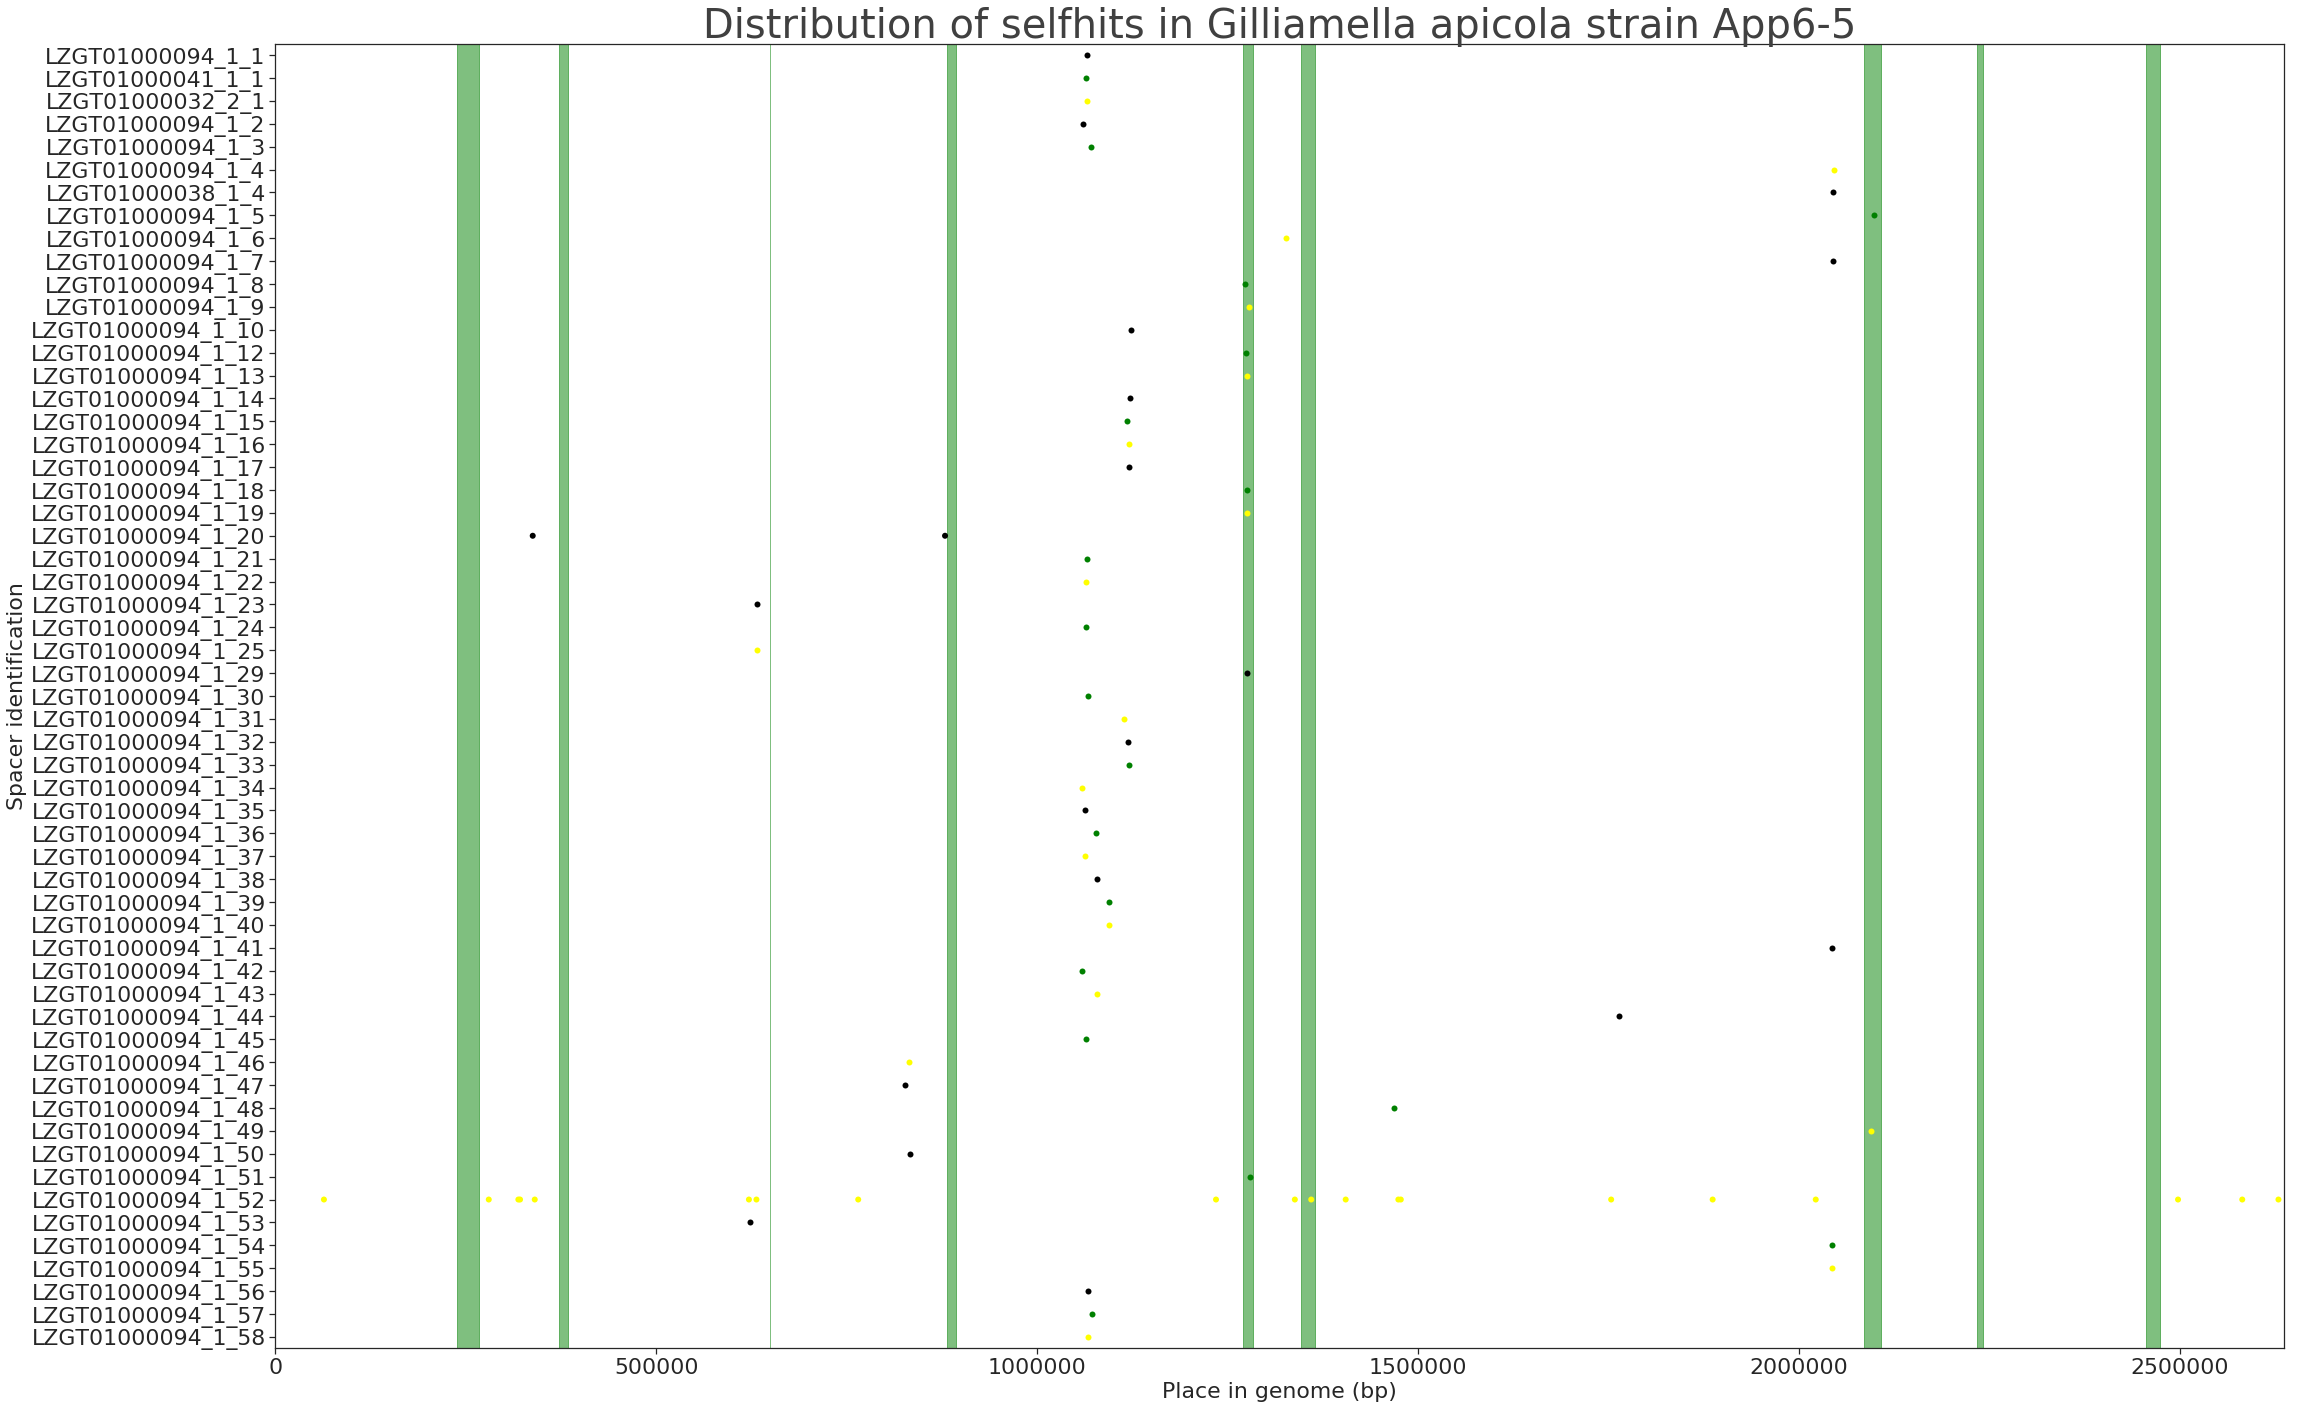

In [27]:
ax = sns.stripplot(data=dfa.sort_values(by='spacer_pos'), 
                   x='start_genome', jitter=0, size=6, y='spacer_id', 
                   palette=['black', 'green', 'yellow'])
increase_size_by(6, 22, plt)
# import matplotlib.transforms as mtransforms
# trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
for span in virsorter_coords:
    ax.axvspan(span[0], span[1], alpha=.5, color='green')
# plt.savefig("place_of_hits_" + genome + ".png", format='png', bbox_inches='tight')
plt.xlim((1, max_length))
plt.title("Distribution of selfhits in %s" % df_genome_info.loc[genome]['name'], size=40)
plt.xlabel("Place in genome (bp)")
plt.ylabel("Spacer identification")
# plt.savefig("/home/hielke/bep/jups/bep_figs/%s.png" % genome, format='png', bbox_inches='tight')